In [1]:
MASKS_DIR = '../Queen_snakes_masks/'
IMAGES_DIR = '../images/'

In [2]:
import os

masks = sorted([f"{MASKS_DIR}/{i}" for i in os.listdir(MASKS_DIR)])
images = sorted([f"{IMAGES_DIR}/{i}" for i in os.listdir(IMAGES_DIR)])

In [3]:
# Check if all images have masks
for image in images:
    image_name = image.split('.')[0]
    if f"{image_name}_mask.png.jpg" not in masks:
        print(image)

../images//PAT_101_1041_898.png.jpg
../images//PAT_1063_271_448.png.jpg
../images//PAT_106_158_270.png.jpg
../images//PAT_1074_322_864.png.jpg
../images//PAT_1089_375_60.png.jpg
../images//PAT_1107_427_352.png.jpg
../images//PAT_113_172_610.png.jpg
../images//PAT_1148_542_708.png.jpg
../images//PAT_115_1138_970.png.jpg
../images//PAT_1180_650_843.png.jpg
../images//PAT_1185_679_115.png.jpg
../images//PAT_118_180_500.png.jpg
../images//PAT_1202_722_827.png.jpg
../images//PAT_1260_894_63.png.jpg
../images//PAT_1303_1077_501.png.jpg
../images//PAT_1304_1081_84.png.jpg
../images//PAT_1345_1223_175.png.jpg
../images//PAT_139_207_342.png.jpg
../images//PAT_1414_1433_570.png.jpg
../images//PAT_1415_1437_743.png.jpg
../images//PAT_1415_1440_629.png.jpg
../images//PAT_1421_1464_297.png.jpg
../images//PAT_1455_1585_690.png.jpg
../images//PAT_145_216_110.png.jpg
../images//PAT_148_220_174.png.jpg
../images//PAT_149_221_679.png.jpg
../images//PAT_1520_1777_935.png.jpg
../images//PAT_1554_2392_767.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def merge_mask_with_image(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    masked_image = cv2.bitwise_and(image, image, mask=binary_mask)
    return masked_image


In [6]:
def display_image(image, title="Image"):
    """Display an image using matplotlib."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


def display_images(images, titles):
    """Display multiple images using matplotlib."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (image, title) in enumerate(zip(images, titles)):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(image_rgb)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

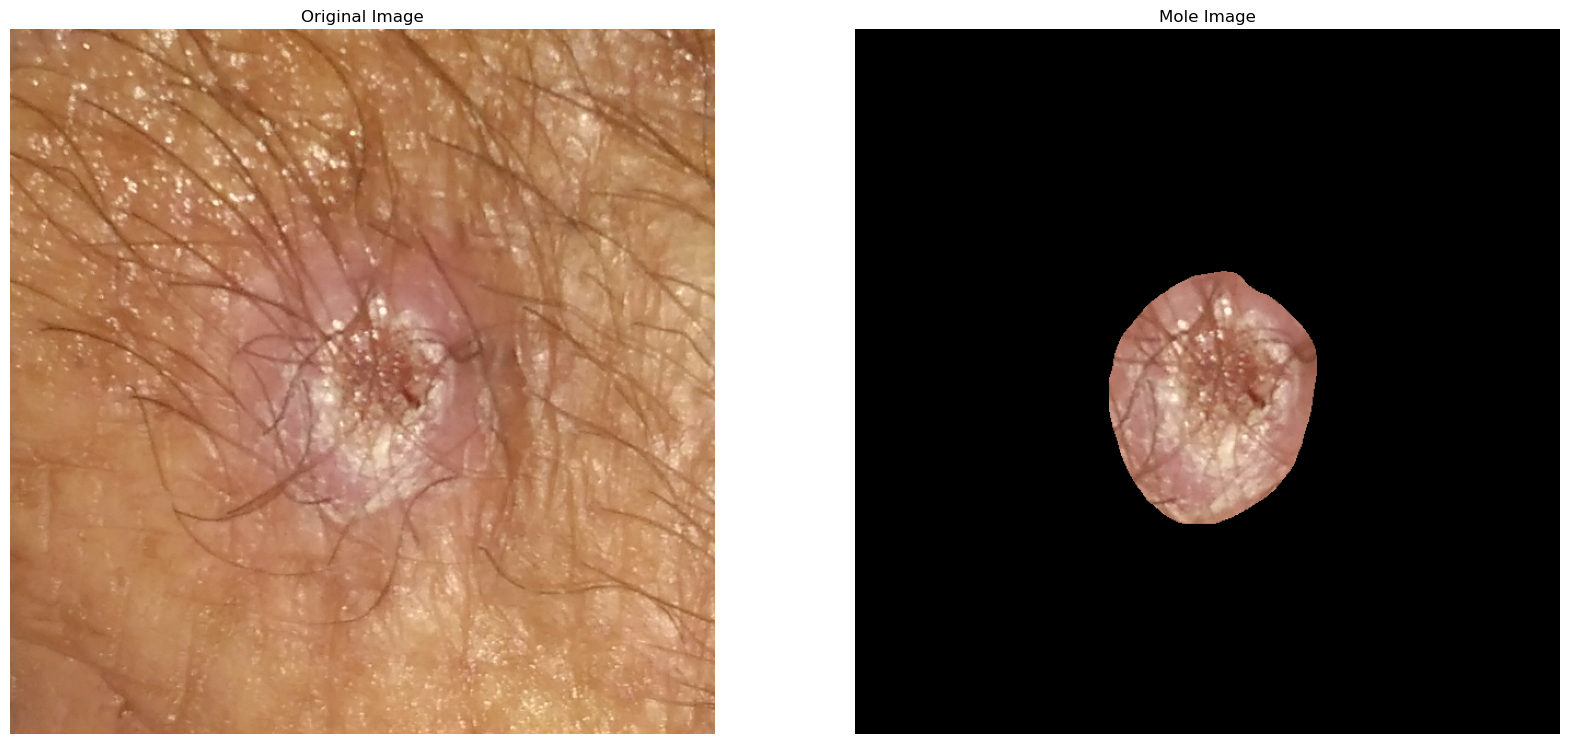

In [7]:
image_with_hair = list(filter(lambda x: x.endswith("PAT_406_808_560.png.jpg"), images))
image_with_hair_index = images.index(image_with_hair[0])

original_image = cv2.imread(images[image_with_hair_index])
mole_image = merge_mask_with_image(images[image_with_hair_index], masks[image_with_hair_index])

display_images([original_image, mole_image], ["Original Image", "Mole Image"])

In [8]:
# remove hair using dull razor algorithm
# source: https://github.com/BlueDokk/Dullrazor-algorithm/blob/main/dullrazor.py
def remove_hair(img):
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Black hat filter
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    # plt.imshow(grayScale)
    # plt.show()
    # plt.imshow(blackhat)
    # plt.show()
    # plt.imshow(bhg)
    # plt.show()
    # plt.imshow(mask)
    # plt.show()
    # 
    return dst

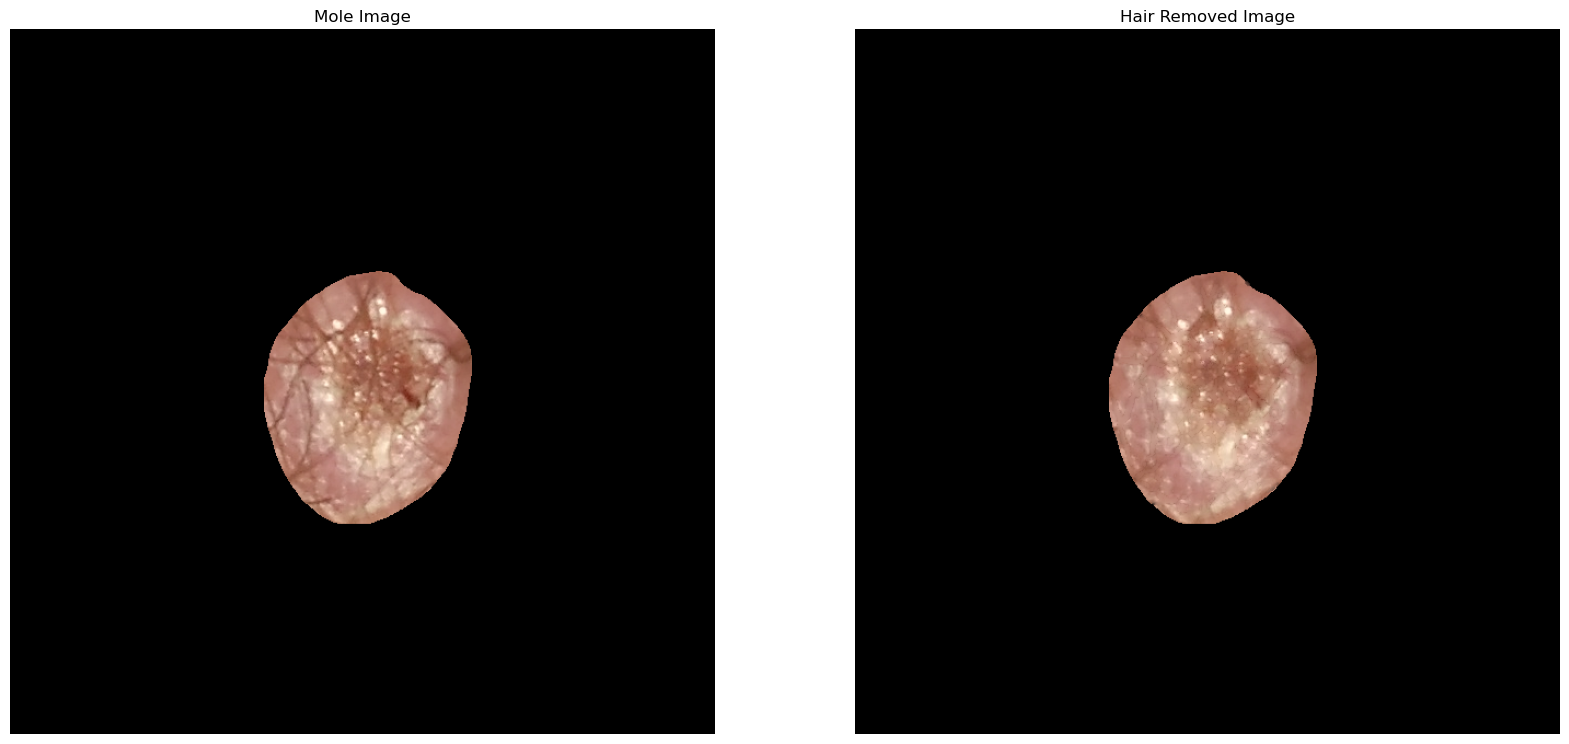

In [9]:
hair_removed = remove_hair(mole_image)
display_images([mole_image, hair_removed], ["Mole Image", "Hair Removed Image"])

In [10]:
# detect presence of the following colors in the image
# white
# red
# light brown
# dark brown
# blue-gray
# black

# using HSV color space

###     White range
white_range = {
    "H": [0, 360],
    "S": [0, 10],
    "L": [95, 100]
}
white_pixels_rate = 0.01
###     Black range
black_range = {
    "H": [0, 360],
    "S": [0, 100],
    "L": [0, 20]
}
black_pixels_rate = 0.01
###     Red range
red_range = [[0, 20], [320, 360], [50, 100], [50, 100]]
red_pixels_rate = 0.01
###     Blue-gray
blue_gray_range = [[190, 220], [30, 100], [20, 100]]
blue_gray_pixels_rate = 0.01
###     Light brown
light_brown_range = [[20, 40], [25, 75], [55, 90]]
light_brown_pixels_rate = 0.01
###     Dark brown
dark_brown_range = [[20, 40], [25, 100], [20, 55]]
dark_brown_pixels_rate = 0.01



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb


def visualize_hsl_range(hsl_range):
    """
    Visualize a range of HSL colors given by the dictionary hsl_range.
    
    Args:
    hsl_range (dict): A dictionary with keys 'H', 'S', 'L' specifying the ranges for hue, saturation, and lightness.
                      Each value should be a two-element list [min, max].
    
    Example:
    hsl_range = { "H": [0, 360], "S": [0, 10], "L": [95, 100] }
    """
    # Extract HSL ranges
    h_range = hsl_range['H']
    s_range = hsl_range['S']
    l_range = hsl_range['L']

    # Generate color points within the specified range
    hue = np.linspace(h_range[0], h_range[1], 361)  # Including endpoint
    saturation = np.linspace(s_range[0], s_range[1], 11) / 100  # Scale to 0-1
    lightness = np.linspace(l_range[0], l_range[1], 6) / 100  # Scale to 0-1

    # Create a mesh grid of HSL values
    h, s, l = np.meshgrid(hue, saturation, lightness, indexing='ij')
    h = h.flatten()
    s = s.flatten()
    l = l.flatten()

    # Convert HSL to RGB using the HSV color space in matplotlib
    v = l + s * np.minimum(l, 1 - l)  # Calculate the equivalent V in HSV
    colors = hsv_to_rgb(np.stack((h / 360, s, v), axis=-1))

    # Create a plot to display the colors
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.imshow([colors], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Visual Spectrum of Colors in HSL Space")
    plt.show()


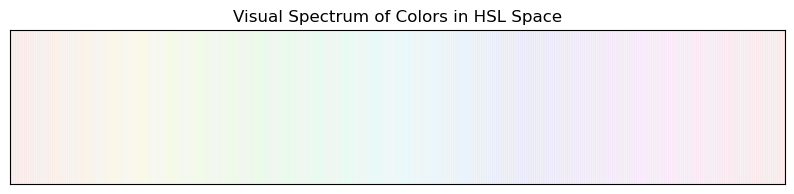

In [12]:
visualize_hsl_range(white_range)

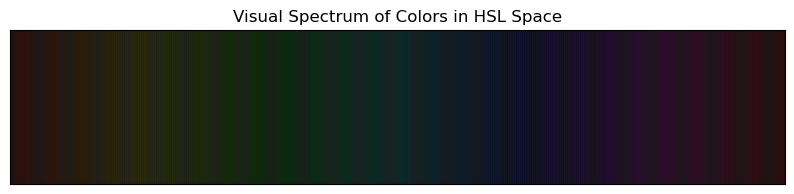

In [13]:
visualize_hsl_range(black_range)

In [14]:
def find_pixels_inside_mask(img):
    pixels_inside_mask = []

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j].all() != 0:
                pixels_inside_mask.append((j, i))

    pixels_number = len(pixels_inside_mask)

    return pixels_inside_mask, pixels_number


In [15]:
def check_white_color(img, pixels_inside_mask, pixels_number):
    count = 0
    for pixel in pixels_inside_mask:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if white_range[0][0] <= HSV_value[1] <= white_range[0][1]:
            if white_range[1][0] <= HSV_value[2] <= white_range[1][1]:
                count = count + 1

    if count >= pixels_number * white_pixels_rate:
        white_val = 1
    else:
        white_val = 0

    print("[INFO] Total pixel number: ", pixels_number)
    print("[INFO] White: ", count)
    return white_val


In [16]:
def check_black_color(img, pixels_inside_cnt, pixels_number):
    count = 0
    for pixel in pixels_inside_cnt:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if HSV_value[2] >= black_range[0] and HSV_value[2] <= black_range[1]:
            count = count + 1

    if count >= pixels_number * black_pixels_rate:
        black_val = 1
    else:
        black_val = 0

    print("[INFO] Black: ", count)
    return black_val


def check_red_color(img, pixels_inside_cnt, pixels_number):
    count = 0
    for pixel in pixels_inside_cnt:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if HSV_value[0] >= red_range[0][0] and HSV_value[0] <= red_range[0][1]:
            if HSV_value[1] >= red_range[2][0] and HSV_value[1] <= red_range[2][1]:
                if HSV_value[2] >= red_range[3][0] and HSV_value[2] <= red_range[3][1]:
                    count = count + 1

        if HSV_value[0] >= red_range[1][0] and HSV_value[0] <= red_range[1][1]:
            if HSV_value[1] >= red_range[2][0] and HSV_value[1] <= red_range[2][1]:
                if HSV_value[2] >= red_range[3][0] and HSV_value[2] <= red_range[3][1]:
                    count = count + 1

    if count >= pixels_number * red_pixels_rate:
        red_val = 1
    else:
        red_val = 0

    print("[INFO] Red: ", count)
    return red_val


def check_blue_gray_color(img, pixels_inside_cnt, pixels_number):
    count = 0
    for pixel in pixels_inside_cnt:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if HSV_value[0] >= blue_gray_range[0][0] and HSV_value[0] <= blue_gray_range[0][1]:
            if HSV_value[1] >= blue_gray_range[1][0] and HSV_value[1] <= blue_gray_range[1][1]:
                if HSV_value[2] >= blue_gray_range[2][0] and HSV_value[2] <= blue_gray_range[2][1]:
                    count = count + 1

    if count >= pixels_number * blue_gray_pixels_rate:
        blue_gray_val = 1
    else:
        blue_gray_val = 0

    print("[INFO] Blue-Gray: ", count)
    return blue_gray_val


def check_light_brown_color(img, pixels_inside_cnt, pixels_number):
    count = 0
    for pixel in pixels_inside_cnt:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if HSV_value[0] >= light_brown_range[0][0] and HSV_value[0] <= light_brown_range[0][1]:
            if HSV_value[1] >= light_brown_range[1][0] and HSV_value[1] <= light_brown_range[1][1]:
                if HSV_value[2] >= light_brown_range[2][0] and HSV_value[2] <= light_brown_range[2][1]:
                    count = count + 1

    if count >= pixels_number * light_brown_pixels_rate:
        light_brown_val = 1
    else:
        light_brown_val = 0

    print("[INFO] Light-brown: ", count)
    return light_brown_val


def check_dark_brown_color(img, pixels_inside_cnt, pixels_number):
    count = 0
    for pixel in pixels_inside_cnt:
        HSV_value = img[pixel[1], pixel[0]]
        HSV_value[0] = HSV_value[0] * 360
        HSV_value[1] = HSV_value[1] * 100
        HSV_value[2] = HSV_value[2] * 100
        if HSV_value[0] >= dark_brown_range[0][0] and HSV_value[0] <= dark_brown_range[0][1]:
            if HSV_value[1] >= dark_brown_range[1][0] and HSV_value[1] <= dark_brown_range[1][1]:
                if HSV_value[2] >= dark_brown_range[2][0] and HSV_value[2] <= dark_brown_range[2][1]:
                    count = count + 1

    if count >= pixels_number * dark_brown_pixels_rate:
        dark_brown_val = 1
    else:
        dark_brown_val = 0

    print("[INFO] Dark-brown: ", count)
    return dark_brown_val

In [17]:
from skimage.color import rgb2hsv


def check_colors(image):
    img_copy = image.copy()
    hsv_image = rgb2hsv(img_copy)
    pixels_inside_mask, pixels_number = find_pixels_inside_mask(image)

    white_val = check_white_color(hsv_image, pixels_inside_mask, pixels_number)
    black_val = check_black_color(hsv_image, pixels_inside_mask, pixels_number)
    red_val = check_red_color(hsv_image, pixels_inside_mask, pixels_number)
    blue_gray_val = check_blue_gray_color(hsv_image, pixels_inside_mask, pixels_number)
    light_brown_val = check_light_brown_color(hsv_image, pixels_inside_mask, pixels_number)
    dark_brown_val = check_dark_brown_color(hsv_image, pixels_inside_mask, pixels_number)

    return white_val, black_val, red_val, blue_gray_val, light_brown_val, dark_brown_val

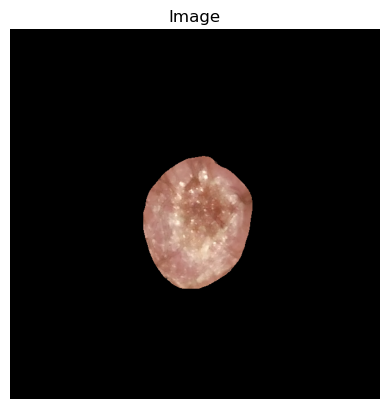

KeyError: 0

In [18]:
display_image(hair_removed)
white_val, black_val, red_val, blue_gray_val, light_brown_val, dark_brown_val = check_colors(hair_removed)